# Import thư viện

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
import copy
from re import sub
from decimal import Decimal
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import geopandas
from dataprep.clean import clean_country

pd.set_option('display.max_columns', None)


# Preprocess


In [2]:
def curr_to_dec(money):
    return float(sub(r'[^\d.]', '', money))
def gdp_preproc(gdp_df):
    gdp_df = gdp_df[['GDP (nominal, 2017)','GDP per capita','Country',"Population (2017)"]]
    gdp_df['GDP (nominal, 2017)'] = gdp_df['GDP (nominal, 2017)'].apply(curr_to_dec)
    gdp_df['GDP per capita'] = gdp_df['GDP per capita'].apply(curr_to_dec)
    gdp_df = clean_country(gdp_df,"Country",output_format="alpha-3")
    return gdp_df
def preproc_col(df):
    return df.rename(columns={"Country,Other":"Country"}).drop(columns=['Unnamed: 0'])
def merge_gdp(df,gdp_df=pd.read_csv("./data/gdp.csv")):
    return gdp_preproc(gdp_df).merge(df,on='Country_clean')
def add_death_per_cases(df):
    df['Deaths/Cases'] = df['TotalDeaths']/df['TotalCases']
    return df
def _preproc(df):
    result = copy.deepcopy(df)
    result = result.drop(df.tail(8).index)    
    result = preproc_col(result)
    result = add_death_per_cases(result)
    result = clean_country(result,"Country",output_format="alpha-3")
    result = result.drop(columns=['Country'])
    result = merge_gdp(result)
    return result.rename(columns={"Country_clean":"CODE"})

In [3]:
df = pd.read_csv('./data/2022-04-27.csv')
df.loc[df['Country,Other'] == 'UK', 'Country,Other'] = 'Great Britain'
df = _preproc(df)
df = df.dropna(axis=0,subset=['Deaths/1M pop','Tot\xa0Cases/1M pop'])
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df[['Country']])

  0%|          | 0/9 [00:00<?, ?it/s]

Country Cleaning Report:
	222 values cleaned (94.07%)
	12 values unable to be parsed (5.08%), set to NaN
Result contains 223 (94.49%) values in the correct format and 13 null values (5.51%)


/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


  0%|          | 0/9 [00:00<?, ?it/s]

Country Cleaning Report:
	190 values cleaned (100.0%)
Result contains 190 (100.0%) values in the correct format and 0 null values (0.0%)


# Vẽ bản đồ dựa vào cột

In [4]:
def world_map_visualize(df,column,_cmap="Reds"):
    # first let us merge geopandas data with our data
# 'naturalearth_lowres' is geopandas datasets so we can use it directly
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    #fix world manually 
    world.loc[world['name'] == 'France', 'iso_a3'] = 'FRA'
    world.loc[world['name'] == 'Norway', 'iso_a3'] = 'NOR'
    world.loc[world['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
    world.loc[world['name'] == 'Kosovo', 'iso_a3'] = 'RKS'
    #----------------------------------
    # rename the columns so that we can merge with our data
    world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
    # then merge with our data 
    merge=pd.merge(world,df,on='CODE')
    # last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude
    location=pd.read_csv('./data/countries.csv')
    location = clean_country(location,"name",output_format="alpha-3")
    merge=merge.merge(location,left_on='CODE',right_on='name_clean')
    # plot confirmed cases world map 
    merge.plot(column=column, scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap=_cmap)
    plt.title(column)
    # add countries names and numbers 
    plt.show()

PROJ: proj_identify: /home/duy/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
Failed to auto identify EPSG: 7


  0%|          | 0/9 [00:00<?, ?it/s]

Country Cleaning Report:
	181 values cleaned (98.37%)
	2 values unable to be parsed (1.09%), set to NaN
Result contains 182 (98.91%) values in the correct format and 2 null values (1.09%)


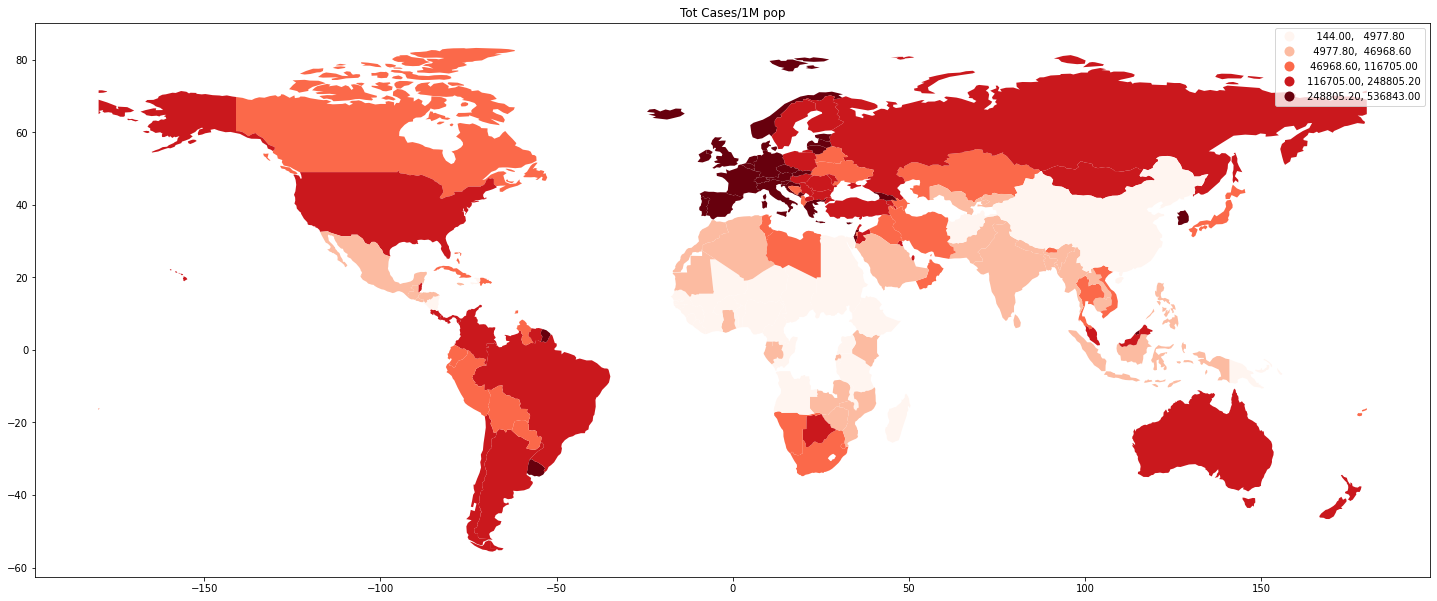

PROJ: proj_identify: /home/duy/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
Failed to auto identify EPSG: 7


  0%|          | 0/9 [00:00<?, ?it/s]

Country Cleaning Report:
	181 values cleaned (98.37%)
	2 values unable to be parsed (1.09%), set to NaN
Result contains 182 (98.91%) values in the correct format and 2 null values (1.09%)


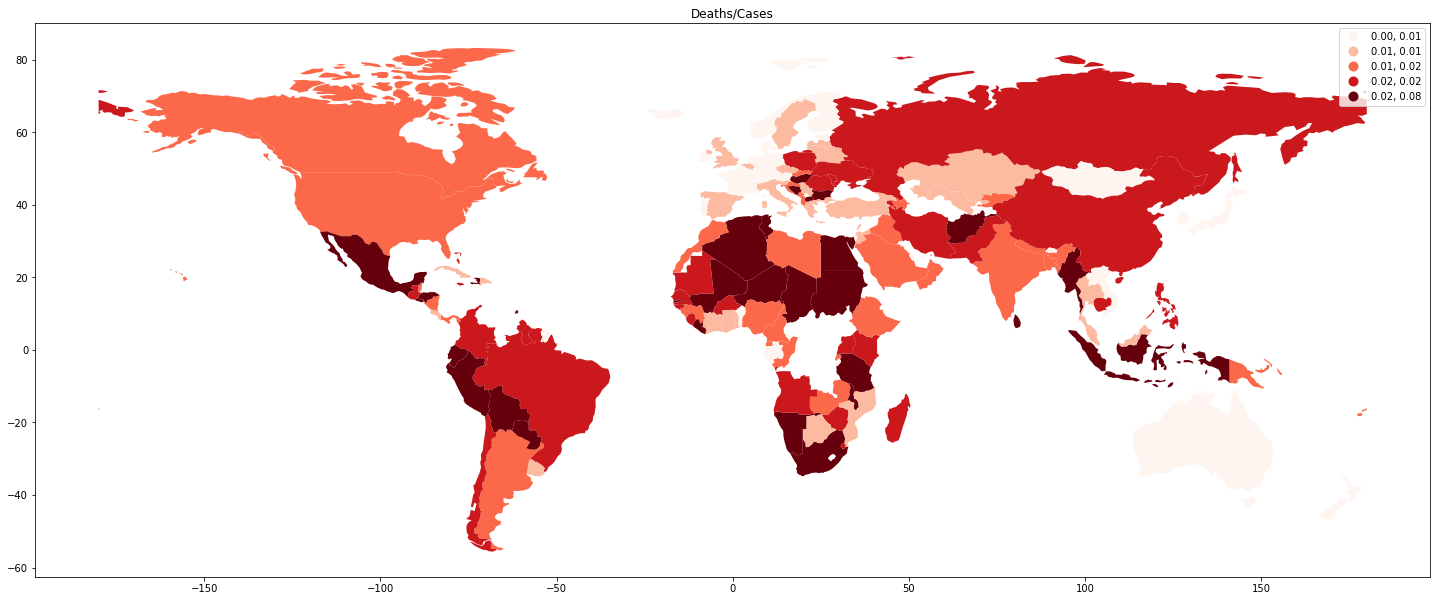

PROJ: proj_identify: /home/duy/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
Failed to auto identify EPSG: 7


  0%|          | 0/9 [00:00<?, ?it/s]

Country Cleaning Report:
	181 values cleaned (98.37%)
	2 values unable to be parsed (1.09%), set to NaN
Result contains 182 (98.91%) values in the correct format and 2 null values (1.09%)


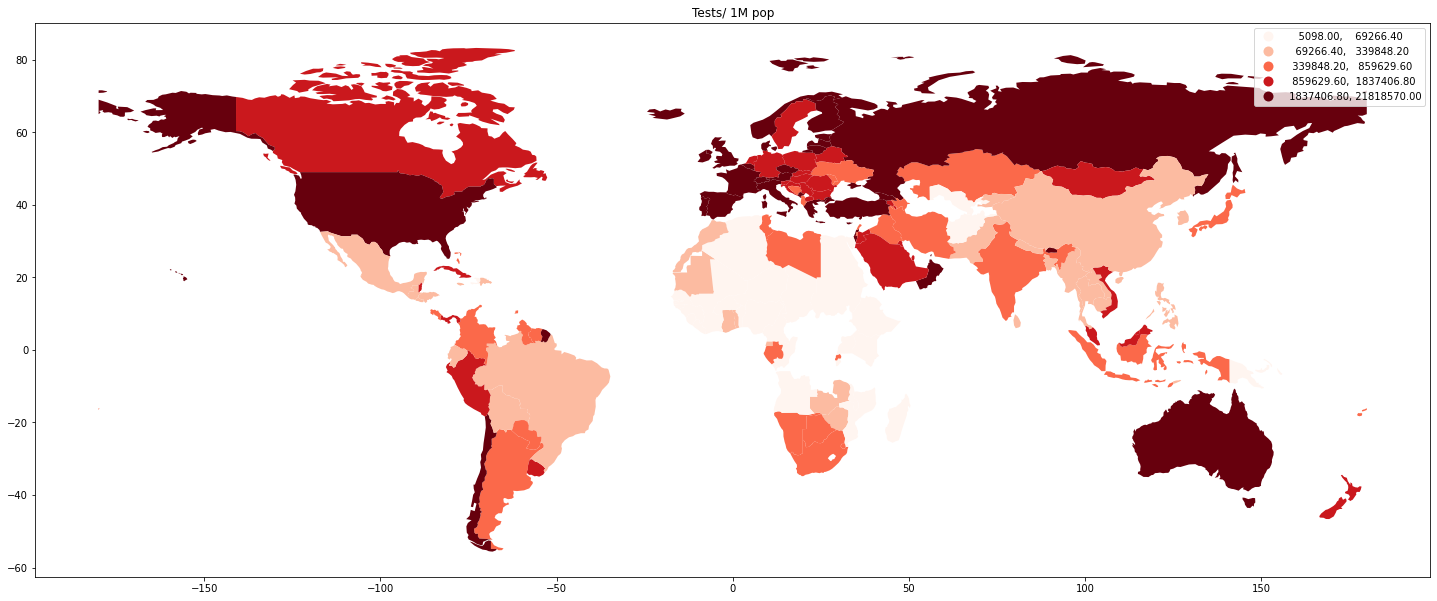

PROJ: proj_identify: /home/duy/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
Failed to auto identify EPSG: 7


  0%|          | 0/9 [00:00<?, ?it/s]

Country Cleaning Report:
	181 values cleaned (98.37%)
	2 values unable to be parsed (1.09%), set to NaN
Result contains 182 (98.91%) values in the correct format and 2 null values (1.09%)


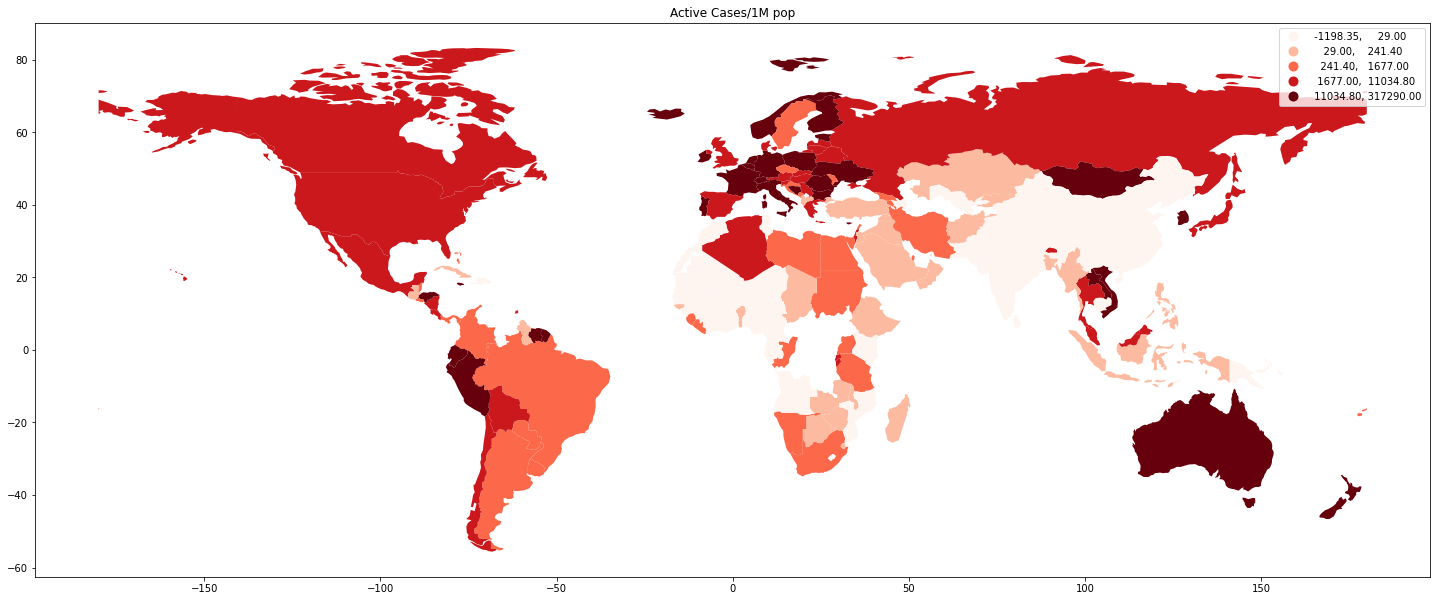

In [5]:
for col in ['Tot\xa0Cases/1M pop','Deaths/Cases', 'Tests/ 1M pop','Active Cases/1M pop']:
    world_map_visualize(df,col)

# Tương quan giữa tỉ lệ nhiễm và tỉ lệ tử vong

<AxesSubplot:xlabel='Tot\xa0Cases/1M pop', ylabel='Deaths/Cases'>

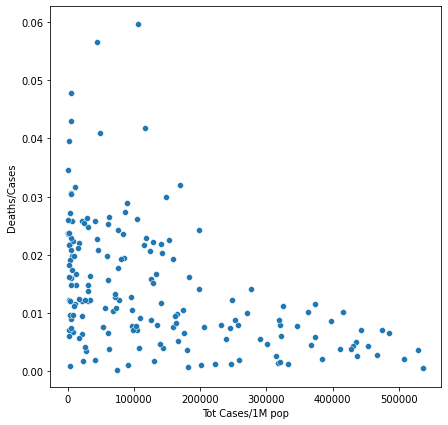

In [6]:
df_1 = copy.deepcopy(df)
# bỏ 2 dòng outlier (theo quan sát bằng mắt)
df_1 = df_1.drop(df_1['Deaths/Cases'].idxmax())
df_1 = df_1.drop(df_1['Deaths/Cases'].idxmax())

f, ax = plt.subplots(figsize=(7, 7))
#ax.set(xscale="log",yscale='log')

sns.scatterplot(x='Tot\xa0Cases/1M pop', y='Deaths/Cases', data=df_1,ax = ax)

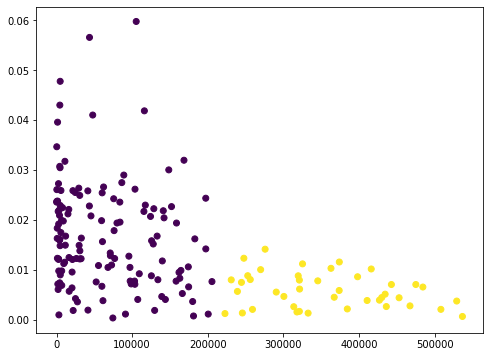

In [7]:
# def kmeans_display(X, label):
#     X0 = X[label == 0]
#     X1 = X[label == 1]
    
#     sns.scatterplot(X0, 'b^', markersize = 4, alpha = .8)
#     #plt.plot(X1, 'go', markersize = 4, alpha = .8)

    
from sklearn.cluster import KMeans
X = df_1[["Deaths/Cases","Tot\xa0Cases/1M pop","GDP per capita"]]
kmeans = KMeans(n_clusters=2).fit(X)
df_1['label'] = kmeans.labels_
plt.figure(figsize=(8, 6))
plt.scatter( df_1["Tot\xa0Cases/1M pop"],df_1["Deaths/Cases"], c=df_1['label'])
plt.show()

# Gom nhóm các nước có dữ liệu giống nhau và trực quan trên bản đồ

PROJ: proj_identify: /home/duy/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
Failed to auto identify EPSG: 7


  0%|          | 0/9 [00:00<?, ?it/s]

Country Cleaning Report:
	181 values cleaned (98.37%)
	2 values unable to be parsed (1.09%), set to NaN
Result contains 182 (98.91%) values in the correct format and 2 null values (1.09%)


/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


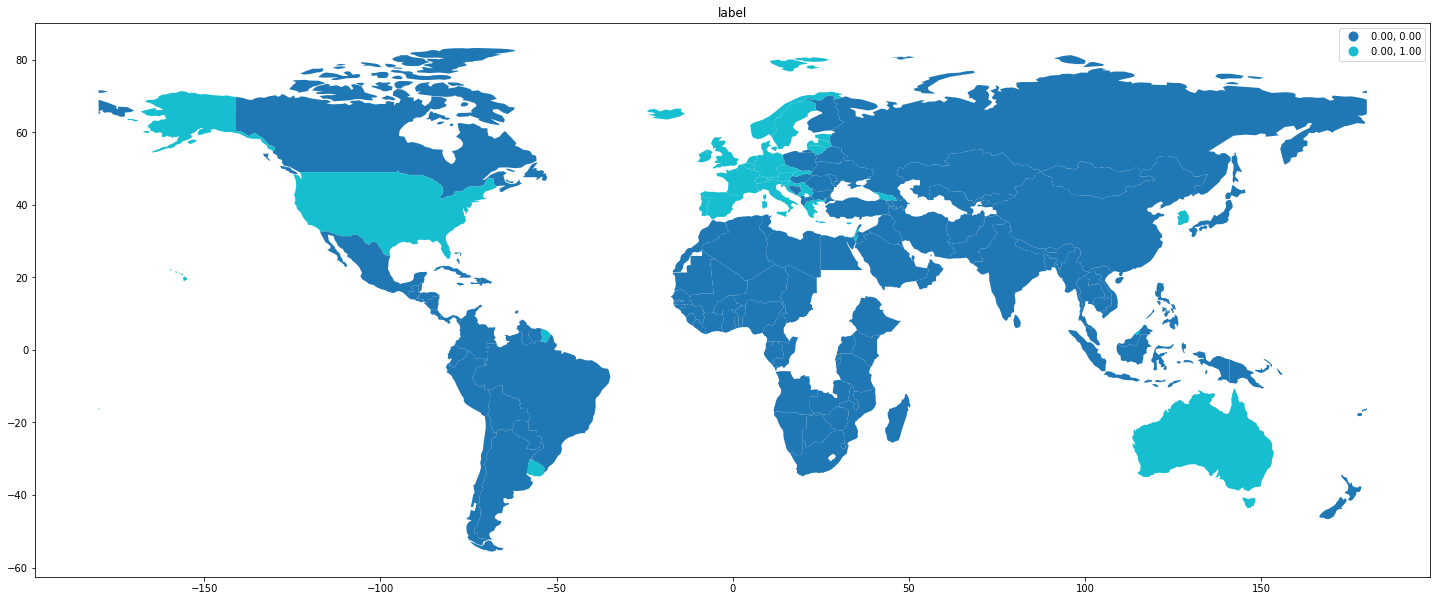

In [8]:
# from sklearn.cluster import KMeans
# X = df[["Deaths/Cases","TotalCases",'GDP (nominal, 2017)']]
# kmeans = KMeans(n_clusters=5).fit(X)
# df['label'] = kmeans.labels_
world_map_visualize(df_1,'label','tab10')

# Số lượng Test nhiều sẽ dẫn đến số lượng mắc Covid nhiều hay không

Ngay trong đại dịch, có ý kiến cho rằng chỉ cần giờ chúng ta ít test lại thì sẽ không phát hiện nhiều case mới, liệu điều này có đúng hay không, thì đây là biểu đồ thể hiện sự quan hệ giữa tổng số ca nhiễm và tổng số mẫu test đã thực hiện dựa trên báo cáo:
Có thể thấy rằng:
* Có vài trường hợp đặc biệt khi các nước test quá nhiều $\rightarrow$ giải quyết bằng cách đưa về đồ thị dạng $\text{log-scale}$
* Sau khi đưa về ta thấy được một mối quan hệ khá là đẹp, dữ liệu gần như tuyến tính, vậy cũng có thể kết luận rằng nếu làm càng nhiều test thì phát hiện được nhiều ca nhiễm hơn

<Figure size 432x288 with 0 Axes>

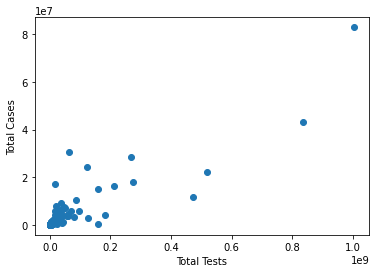

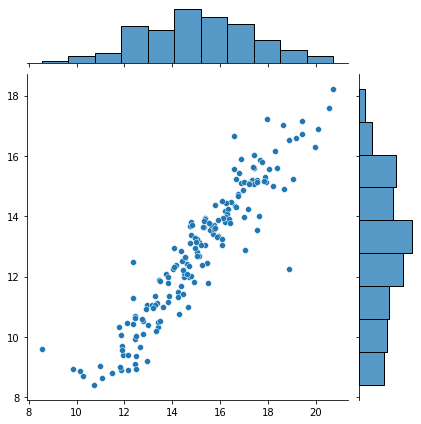

In [9]:
def _visualize_Ntest_and_Ncases(df):
    """
    
    N_tests_fig = plt.figure()
    N_tests_ax = N_tests_fig.add_subplot()
    N_tests_ax.hist(N_tests_dropna)
    N_tests_ax.set(xscale="log")
    N_tests_fig.show()
    """
    Ntests_and_Ncases = df[['TotalCases','TotalTests',"CODE"]]
    Ntests_and_Ncases_dropna = Ntests_and_Ncases.dropna()
    fig = plt.figure()
    fige = plt.figure()
    #ax = fig.add_subplot()
    
    #ax.set(xlabel="Log of Total Tests", ylabel="Log of Total Cases")
    sns.jointplot(x = np.log(Ntests_and_Ncases_dropna['TotalTests'].to_list()), y = np.log(Ntests_and_Ncases_dropna['TotalCases'].to_list()))
    axe = fige.add_subplot()
    
    axe.set( xlabel="Total Tests", ylabel="Total Cases")
    axe.scatter(Ntests_and_Ncases_dropna['TotalTests'].to_list(), Ntests_and_Ncases_dropna['TotalCases'].to_list())
    #return Ntests_and_Ncases_dropna
_visualize_Ntest_and_Ncases(df)

In [10]:
CONTINENT = df['Continent'].unique()
CONTINENT

array(['North America', 'Asia', 'Europe', 'South America',
       'Australia/Oceania', 'Africa'], dtype=object)

{'TotalDeaths': {'North America': 1455836.0, 'Asia': 1416093.0, 'Europe': 1813703.0, 'South America': 1287776.0, 'Australia/Oceania': 9495.0, 'Africa': 249619.0}, 'TotalCases': {'North America': 97674185, 'Asia': 146454949, 'Europe': 190013263, 'South America': 56138261, 'Australia/Oceania': 6863541, 'Africa': 11302273}, 'ActiveCases': {'North America': 2277012.0, 'Asia': 3141766.0, 'Europe': 10445960.0, 'South America': 487309.0, 'Australia/Oceania': 403042.0, 'Africa': 391354.0}}
TotalDeaths of the whole world: 6232522.0
TotalCases of the whole world: 508446472
ActiveCases of the whole world: 17146443.0


/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


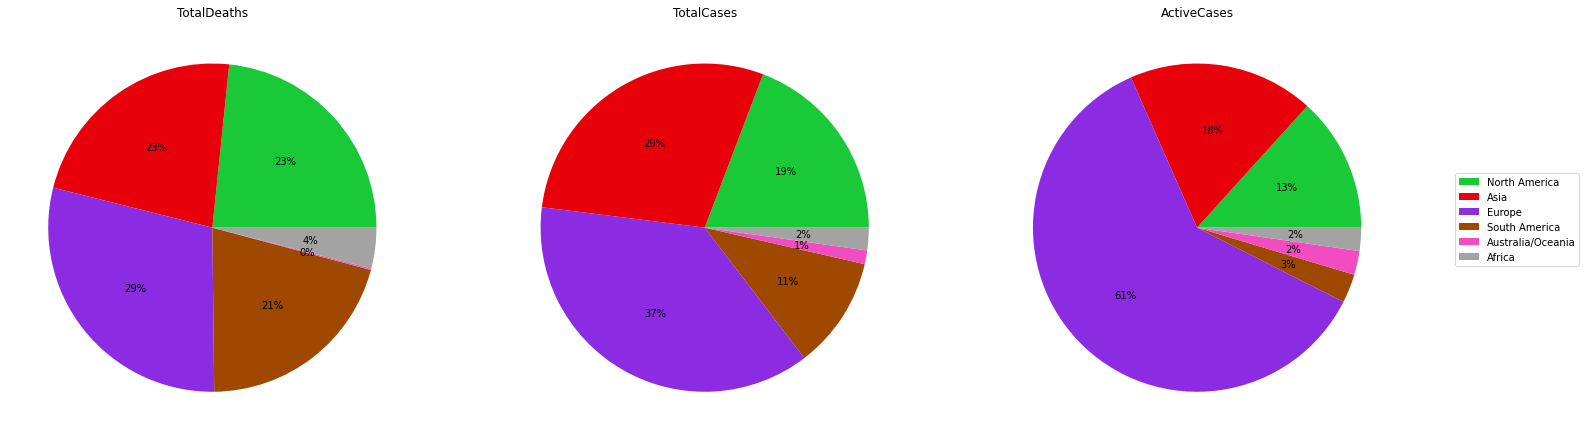

In [11]:
def _circular_percentage_death(df, continents, columns = ["TotalDeaths"]):
    dic = {}
    for k in columns:
        dic.update({k: {}})
    def _update_xs_of_continents(df,dic,continent, column):
        filt = df["Continent"] == continent
        continent_total_x = (df[filt])[column].sum()
    #    print(continent_total_deaths)
        dic[column].update({continent: continent_total_x})
        return dic
    
    
    # Using above function using for loop
    for conti in continents:
        for col in columns:
            dic = _update_xs_of_continents(df, dic, conti, col)
    print(dic)
    #for k,v in dic:
    #    print(k,v)
    data = {}
    labels = {}
    #plt.style.use('ggplot')
    for col in columns:
        
        sum_ = sum([v for k,v in dic[col].items()])
        print(f"{col} of the whole world: {sum_}")
    
    #define data
        data[col] = [v for k,v in dic[col].items()]
        labels[col] = [k for k in dic[col]]

    #def ine Seaborn color palette to use
    colors = sns.color_palette('bright')[2:8]
    fig, ax = plt.subplots(ncols=len(columns),figsize=(25,25),squeeze=False)
    for i in range(len(columns)):
        col = columns[i]
        dn = ax[0,i].pie(data[col], colors=colors, autopct='%.0f%%')
        ax[0,i].set(ylabel='', title=col, aspect='equal')
    #create pie chart
    #fig.figsize((15,15))
    #ax.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    fig.legend(dn[0],continents,loc="right")
    fig.show()
_circular_percentage_death(df, CONTINENT, columns= ["TotalDeaths", "TotalCases","ActiveCases"])
        

In [12]:
df = pd.read_csv('./data/2022-04-27.csv')
df = df.drop(columns=['Unnamed: 0','#']).rename(columns={"Country,Other":"Country"})
df.drop([0,1,2,3,4,5,6,7,236,237,238,239,240,241,242,243], inplace = True)
df

,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop,Population,Continent,1 Caseevery X ppl,1 Deathevery X ppl,1 Testevery X ppl,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
8,China,207081,1824.0,4876.0,48.0,175431.0,3728.0,26774.0,318.0,144.0,3.0,1.600000e+08,111163.0,1.439324e+09,Asia,6951.0,295185.0,9.0,1.0,0.03,19.0
9,USA,82888247,57738.0,1019774.0,311.0,80585919.0,36051.0,1282554.0,1520.0,247777.0,3048.0,1.003323e+09,2999223.0,3.345276e+08,North America,4.0,328.0,0.0,173.0,0.90,3834.0
10,India,43068799,3133.0,523693.0,39.0,42528126.0,2563.0,16980.0,698.0,30662.0,373.0,8.359741e+08,595150.0,1.404643e+09,Asia,33.0,2682.0,2.0,2.0,0.03,12.0
11,Brazil,30399004,20943.0,663165.0,224.0,29480998.0,69185.0,254841.0,8318.0,141191.0,3080.0,6.377617e+07,296215.0,2.153034e+08,South America,7.0,325.0,3.0,97.0,1.00,1184.0
12,France,28483124,67711.0,145579.0,152.0,26403836.0,158622.0,1933709.0,1677.0,434619.0,2221.0,2.664840e+08,4066235.0,6.553581e+07,Europe,2.0,450.0,0.0,1033.0,2.00,29506.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,MS Zaandam,9,NaN,2.0,NaN,7.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232,Niue,8,NaN,NaN,NaN,7.0,NaN,1.0,NaN,4860.0,NaN,NaN,NaN,1.646000e+03,Australia/Oceania,206.0,NaN,NaN,NaN,NaN,608.0
233,Nauru,4,1.0,NaN,NaN,3.0,NaN,1.0,NaN,365.0,NaN,NaN,NaN,1.094800e+04,Australia/Oceania,2737.0,NaN,NaN,91.0,NaN,91.0
234,Micronesia,3,NaN,NaN,NaN,1.0,NaN,2.0,NaN,26.0,NaN,NaN,NaN,1.172130e+05,Australia/Oceania,39071.0,NaN,NaN,NaN,NaN,17.0


In [13]:
sns.set_theme(style="whitegrid")

# Checking the distribution of (NewRecovered/ NewCases) ratio which determine the speed rate of approaching normal status of each country
- If this rate more over 1 => good rate, good sign
- If this rate closer to 0 => bad sign

In [14]:
df['to_normal_speed_rate'] = df['NewRecovered'].fillna(0)/df['NewCases'].fillna(0)

Text(0.5, 1.0, 'distribution of approach_to_normal rate (date:27.4.2022)')

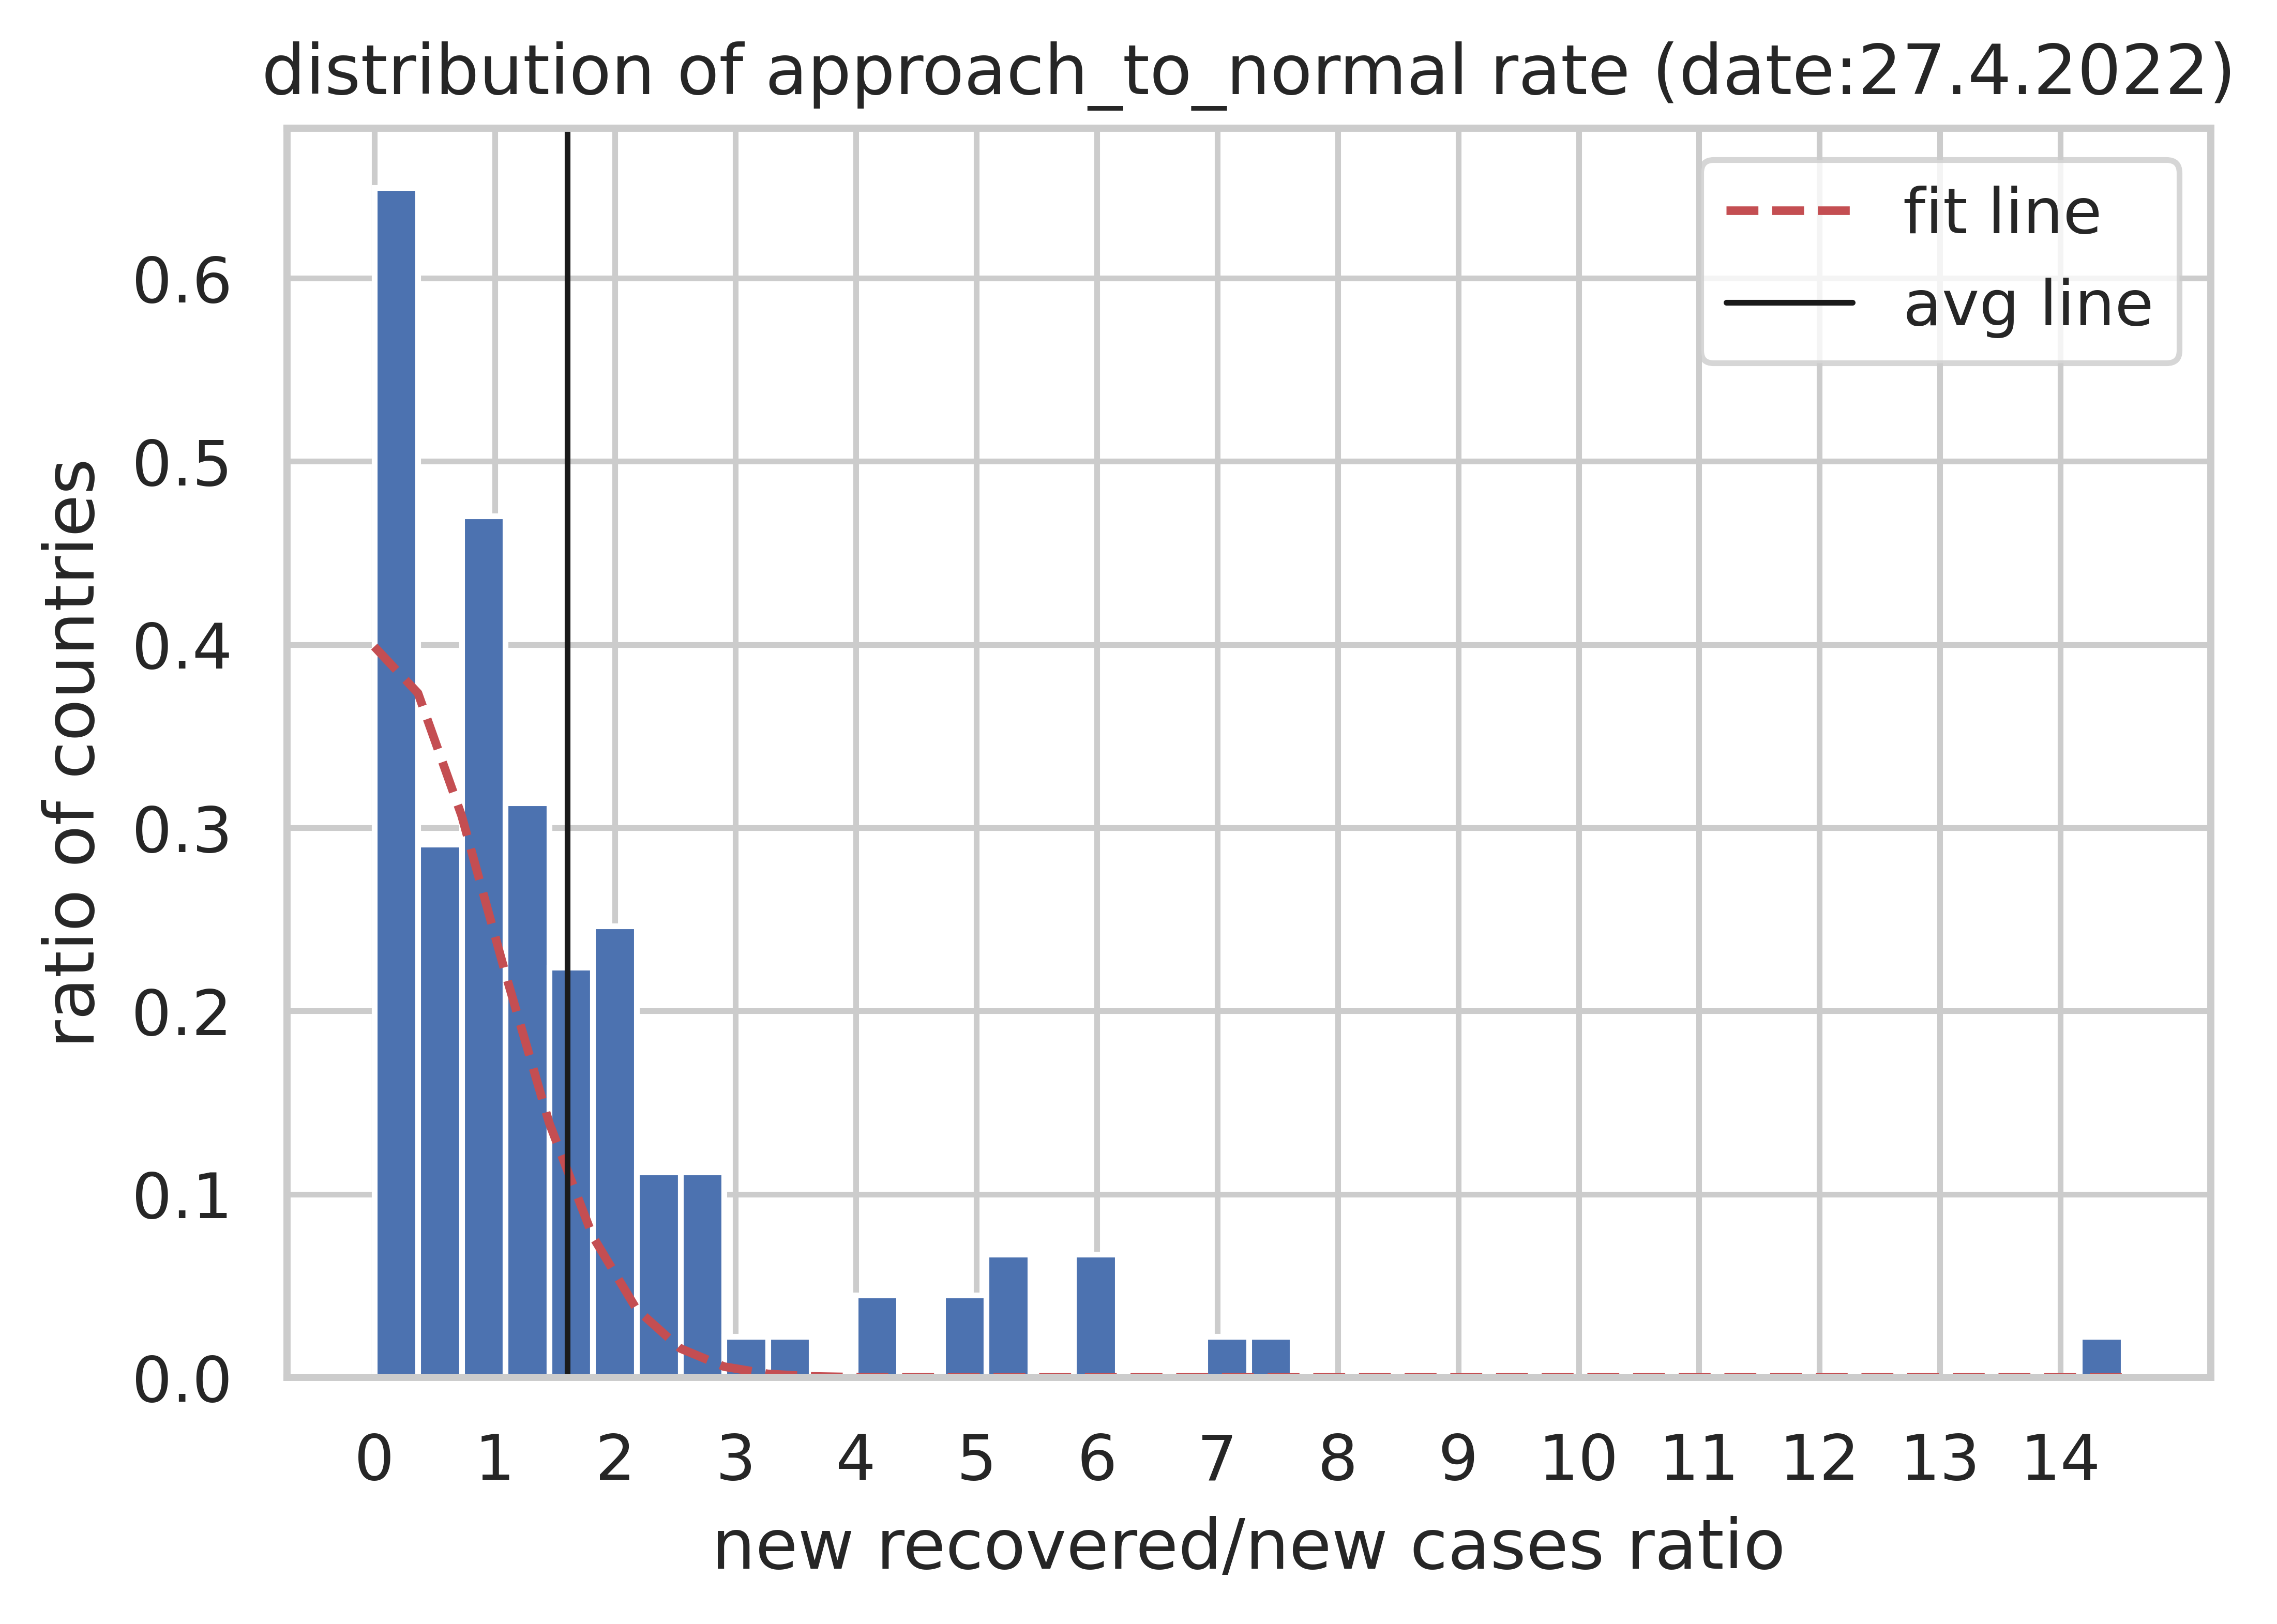

In [15]:
data = df[df['to_normal_speed_rate']!=np.inf]['to_normal_speed_rate'].dropna()

sigma = 1
mu = 0
fig, axe = plt.subplots(dpi=800)

n, bins, _ = axe.hist(data, bins=40, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *np.exp(-0.5 * (1 / sigma * (bins - mu))**2))

axe.plot(bins, y, '--', color='r', label = 'fit line')

axe.axvline(data.mean(), color='k', linewidth=1, label = 'avg line')

axe.legend()
plt.xticks(np.arange(min(data), max(data), step=1))
plt.xlabel('new recovered/new cases ratio')
plt.ylabel('ratio of countries')
plt.title('distribution of approach_to_normal rate (date:27.4.2022)')

# TotalRecovered over TotalCases by top 10 max total cases country

In [16]:
df.sort_values("TotalCases", ascending=False, inplace=True)
df.dropna(subset=['TotalRecovered'], inplace = True)

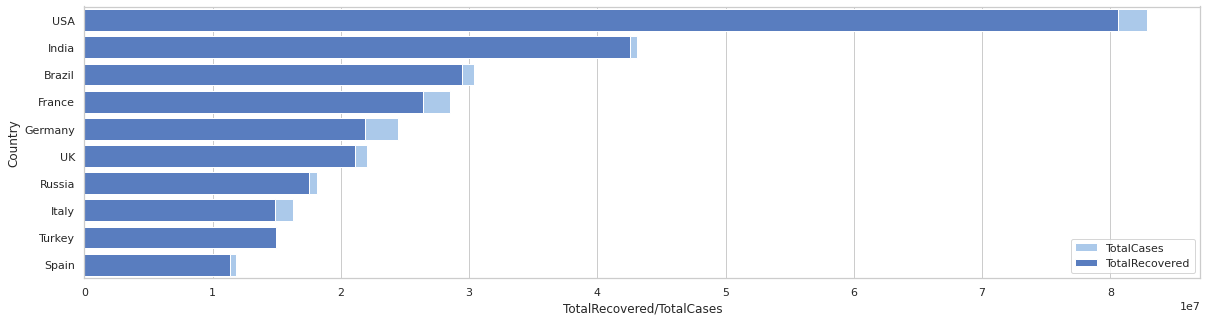

In [17]:
f, ax = plt.subplots(figsize=(20, 5))

n=10

sns.set_color_codes("pastel")
sns.barplot(x="TotalCases", y="Country", data=df[:n], label="TotalCases", color="b")

sns.set_color_codes("muted")
sns.barplot(x="TotalRecovered", y="Country", data=df[:n], label="TotalRecovered", color="b")

plt.xlabel("TotalRecovered/TotalCases")

plt.legend()

# Cause effect : May test have relationship to cases
Để công bằng ta quy đồng số lượng test và số lượng cases trên 1M dân số, nên ta trực quan trên 2 trường dữ liệu là Tests/ 1M pop, Tot Cases/1M pop 

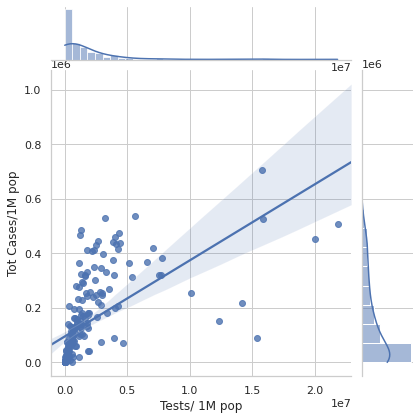

In [18]:
g = sns.jointplot(x="Tests/ 1M pop", y="Tot Cases/1M pop", data=df,  kind="reg", truncate=False)